**카사바 잎사귀 질병 분류 경진대회**

https://www.tensorflow.org/guide 참고자료  
https://www.kaggle.com/c/cassava-leaf-disease-classification/data 데이터 다운로드 

이 노트북은 데이터를 로드하고, 고급 데이터 증대를 적용하고, EfficientNet을 훈련시키고,모델을 사용하여 테스트 이미지를 예측하는 과정을 거친다
데이터는 교육용 80% ,검증용 20%로, 원본 이미지 크기로 인해 가능한 최고의 이미지 해상도를 유지하기 위해  
원본 이미지에서 512X512 이미지를 무작위로 잘라보려한다

In [ ]:
# 각종 라이브러리 불러오기
import numpy as np
import pandas as pd
from PIL import Image # 파이썬 인터프리터에 다양한 이미지 파일 형식을 지원하고 강력한 이미지 처리와 그래픽 기능을 제공
import os
import matplotlib.pyplot as plt  
import seaborn as sns
from tqdm import tqdm # 진행표시바 사용
from sklearn.utils import shuffle 
from sklearn.utils import class_weight 
from sklearn.preprocessing import minmax_scale # 최소값과 최대값을 이용해 0~1 범위 변환
import random
import cv2
from imgaug import augmenters as iaa # 이미지 데이터 확대
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
# 각종 케라스 모듈들
from tensorflow.keras.models import Sequential, Model # 모델 생성
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D # 레이어 모듈
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation # 레이어 모듈

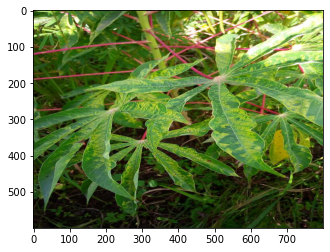

In [ ]:
# 이미지 확인
img = Image.open("../input/cassava-leaf-disease-classification/train_images/3412658650.jpg")
plt.imshow(img)
plt.show()

## 훈련 및 검증 데이터 생성

In [ ]:
training_folder = '../input/cassava-leaf-disease-classification/train_images/'

In [ ]:
samples_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
samples_df = shuffle(samples_df, random_state=42)
samples_df["filepath"] = training_folder+samples_df["image_id"]
samples_df.head()

,image_id,label,filepath
9134,2615227158.jpg,4,../input/cassava-leaf-disease-classification/t...
1580,1277648239.jpg,3,../input/cassava-leaf-disease-classification/t...
7304,2305895487.jpg,3,../input/cassava-leaf-disease-classification/t...
13196,336299725.jpg,2,../input/cassava-leaf-disease-classification/t...
5333,1951270318.jpg,2,../input/cassava-leaf-disease-classification/t...


제공된 데이터의 80%를 교육용으로 유지하고, 나머지 20%는 검증용으로 놔둔다

In [ ]:
# 데이터 나누기
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage) # 전체 데이터 수에 0.8 곱하기
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage) # 데이터 전체 수에서 데이터 수 곱하기 0.8 한 값을 빼준다
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

처음에는 원본 이미지에서 300 x 300으로 잘랐는데, 무작위로 자르다보니  
좋은 결과가 안나오는거같아서 512x512 사이즈로 바꿔봤다

In [ ]:
batch_size = 8
image_size = 512
input_shape = (image_size, image_size, 3) # 인풋 크기 512x512x3
dropout_rate = 0.4
classes_to_predict = sorted(training_df.label.unique()) # 정렬 

tf.data 사용해 데이터 프레임에서 데이터 불러오기

In [ ]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

In [ ]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE # 오토튠을 사용하면 tf.data 런타임이 실행할때 동적으로 값을 조정하도록 만듬

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE) # map 함수 사용
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [ ]:
training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

adapt 함수 사용

In [ ]:
adapt_data = tf.data.Dataset.from_tensor_slices(training_df.filepath.values)
def adapt_mode(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

adapt_data = adapt_data.map(adapt_mode, num_parallel_calls=AUTOTUNE)
adapt_data_batches = adapt_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

아래의 증강 전처리 레이어는 모델을 학습할 때 사용되는데  
추론에서는 비활성화 된다  

In [ ]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=image_size, width=image_size), # 원하는 높이와 너비로 이미지를 무작위로 자른다
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # 각 이미지를 가로 세로로 무작위로 뒤집는다
        layers.experimental.preprocessing.RandomRotation(0.25), # 각 이미지를 무작위로 회전
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)), # 훈련중 각 이미지를 무작위로 확대
        layers.experimental.preprocessing.RandomContrast((0.2,0.2)) # 임의의 요소로 이미지의 대비를 조정
    ]
)

위의 과정을 거친 이미지를 확인

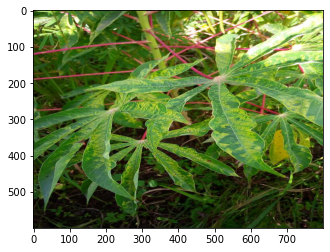

In [ ]:
image = Image.open("../input/cassava-leaf-disease-classification/train_images/3412658650.jpg")
plt.imshow(image)
plt.show()

In [ ]:
image = tf.expand_dims(np.array(image), 0)

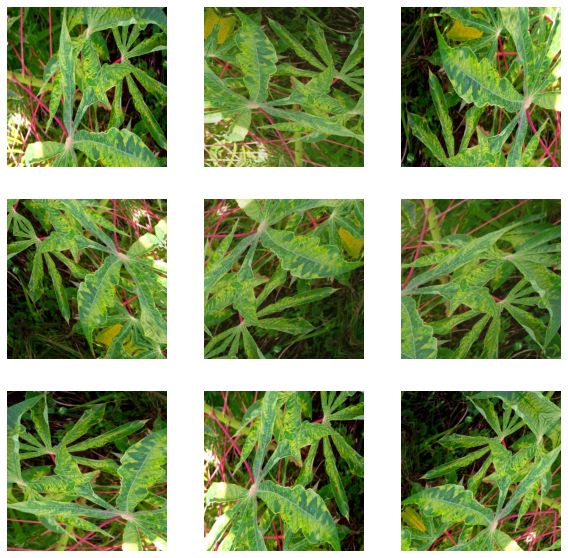

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation_layers(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## 모델 만들기

아까 위에서 말했던 EfficientNetB3 을 사용해볼 차례다  
기본적으로 불러온 모델에 몇가지 레이어를 추가해봤다  
() 안의 수치는 얼마나 해야 좋을지 아직 모르겠다

In [ ]:
efficientnet = EfficientNetB3(weights="../input/tfkerasefficientnetimagenetnotop/efficientnetb3_notop.h5", 
                              include_top=False, 
                              input_shape=input_shape, 
                              drop_connect_rate=dropout_rate)

inputs = Input(shape=input_shape)
augmented = data_augmentation_layers(inputs)
efficientnet = efficientnet(augmented)
pooling = layers.GlobalAveragePooling2D()(efficientnet)
dropout = layers.Dropout(dropout_rate)(pooling)
outputs = Dense(len(classes_to_predict), activation="softmax")(dropout)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
_____________________________________

In [ ]:
# efficientnetb3 계층 정규화 시간 측정
%%time
model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_data_batches)

CPU times: user 14min 7s, sys: 2min 8s, total: 16min 16s
Wall time: 13min 6s


CosineDecay 라는 함수가 tensorflow 2.3.1버전에 추가가 되었다고 한다  
모델을 훈련할 때 훈련이 진행됨에 따라 학습률을 낮추는게 좋은데,  
CosineDecay 함수가 도움을 줄 수 있을것이라 한다  
 https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/cosine_decay

In [ ]:
epochs = 8
decay_steps = int(round(len(training_df)/batch_size))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

## 학습 과정 확인

먼저 훈련과 검증 모두에서 비슷한 수준에서 수행하는지 확인한다  
아래 그래프는 결과가 과적합인지 아니면 훈련을 너무 적게했는지 알려준다

In [ ]:
history = model.fit(training_data_batches,
                  epochs = epochs, 
                  validation_data=validation_data_batches,
                  callbacks=callbacks)

Epoch 1/8
2140/2140 [==============================] - 1249s 584ms/step - loss: 0.5753 - accuracy: 0.7994 - val_loss: 0.4388 - val_accuracy: 0.8472
Epoch 2/8
2140/2140 [==============================] - 1236s 578ms/step - loss: 0.4430 - accuracy: 0.8523 - val_loss: 0.4139 - val_accuracy: 0.8530
Epoch 3/8
2140/2140 [==============================] - 1240s 579ms/step - loss: 0.4004 - accuracy: 0.8650 - val_loss: 0.3783 - val_accuracy: 0.8687
Epoch 4/8
2140/2140 [==============================] - 1241s 580ms/step - loss: 0.3688 - accuracy: 0.8749 - val_loss: 0.3577 - val_accuracy: 0.8785
Epoch 5/8
2140/2140 [==============================] - 1240s 579ms/step - loss: 0.3413 - accuracy: 0.8858 - val_loss: 0.3772 - val_accuracy: 0.8736
Epoch 6/8
2140/2140 [==============================] - 1474s 689ms/step - loss: 0.3214 - accuracy: 0.8923 - val_loss: 0.3602 - val_accuracy: 0.8787
Epoch 7/8
2140/2140 [==============================] - 1243s 581ms/step - loss: 0.3048 - accuracy: 0.8949 - val_

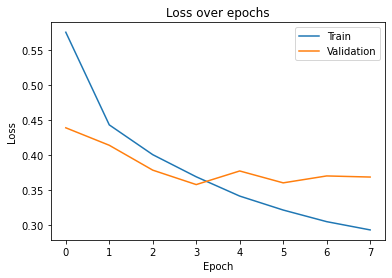

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

아까 훈련할때 저장했던 best_model.h5를 불러와 가중치를 설정한다  


In [ ]:
model.load_weights("best_model.h5")

In [ ]:
def scan_over_image(img_path, crop_size=512):
    # 원본 이미지를 포함하는 512x512 이미지를 추출, 조금씩 겹치는 부분이 있을수도 있다
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height-crop_size) # 0 에서 (이미지 높이 - 512) 사이의 랜덤 숫자 뽑아내기 
    x = random.randint(0,img_width-crop_size) # 0 에서 (이미지 넓이 - 512) 사이의 랜덤 숫자 뽑아내기

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return np.array(img_list)

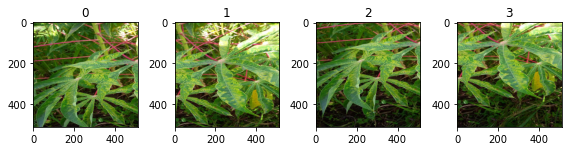

In [ ]:
def display_samples(img_path):
  
    # 원본 이미지에서 추출한 모든 512x512 이미지

    img_list = scan_over_image(img_path)
    sample_number = len(img_list)
    fig = plt.figure(figsize = (8,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(img_list[i])
        ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

display_samples("../input/cassava-leaf-disease-classification/train_images/3412658650.jpg")

tf.keras 사용해서 전처리

In [ ]:
test_time_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0.2)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [ ]:
def predict_and_vote(image_filename, folder, TTA_runs=4):
    
    # 주어진 이미지의 4개 로컬 영역에서 모델을 실행

    
    
    #4개의 이미지 각각에 TTA를 적용하고 각 로컬 이미지에 대한 모든 예측을 합산
    localised_predictions = []
    local_image_list = scan_over_image(folder+image_filename)
    for local_image in local_image_list:
        local_image = tf.expand_dims(local_image,0)
        augmented_images = [test_time_augmentation_layers(local_image) for i in range(TTA_runs)]
        predictions = model.predict(np.array(augmented_images[0]))
        localised_predictions.append(np.sum(predictions, axis=0))
    
    #4개의 이미지 모두에서 모든 예측을 수행하고 가장 높은 값의 인덱스를 검색
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)
    
    return final_prediction

In [ ]:
def run_predictions_over_image_list(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder))
    return predictions

In [ ]:
validation_df["results"] = run_predictions_over_image_list(validation_df["image_id"], training_folder)

100%|██████████| 4280/4280 [25:00<00:00,  2.85it/s]


라벨 분류한거

In [ ]:
!cat ../input/cassava-leaf-disease-classification/label_num_to_disease_map.json

{"0": "Cassava Bacterial Blight (CBB)", "1": "Cassava Brown Streak Disease (CBSD)", "2": "Cassava Green Mottle (CGM)", "3": "Cassava Mosaic Disease (CMD)", "4": "Healthy"}


In [ ]:
validation_df[:20]

,image_id,label,filepath,results
10234,2824543301.jpg,3,../input/cassava-leaf-disease-classification/t...,3
4763,184909120.jpg,3,../input/cassava-leaf-disease-classification/t...,3
9062,2602456265.jpg,3,../input/cassava-leaf-disease-classification/t...,3
1874,1331491784.jpg,3,../input/cassava-leaf-disease-classification/t...,3
17431,414363375.jpg,3,../input/cassava-leaf-disease-classification/t...,3
13682,3448635186.jpg,3,../input/cassava-leaf-disease-classification/t...,3
20631,84689733.jpg,1,../input/cassava-leaf-disease-classification/t...,1
5831,2038307832.jpg,3,../input/cassava-leaf-disease-classification/t...,3
19329,611582421.jpg,3,../input/cassava-leaf-disease-classification/t...,3
191,1036133928.jpg,3,../input/cassava-leaf-disease-classification/t...,3


In [ ]:
true_positives = 0
prediction_distribution_per_class = {"0":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "1":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "2":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "3":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "4":{"0": 0, "1": 0, "2":0, "3":0, "4":0}}
number_of_images = len(validation_df)
for idx, pred in validation_df.iterrows():
    if int(pred["label"]) == pred.results:
        true_positives+=1
    prediction_distribution_per_class[str(pred["label"])][str(pred.results)] += 1
print("accuracy: {}%".format(true_positives/number_of_images*100))

accuracy: 88.43457943925233%


결과값이 88.4345... 으로 나온다
이미지 크기를 300x300으로 했을때 87점대의 결과가 나왔으니 아주 약간 개선된거같다  

In [ ]:
prediction_distribution_per_class

{'0': {'0': 134, '1': 20, '2': 2, '3': 14, '4': 55},
 '1': {'0': 21, '1': 343, '2': 6, '3': 18, '4': 43},
 '2': {'0': 5, '1': 12, '2': 376, '3': 46, '4': 27},
 '3': {'0': 3, '1': 8, '2': 44, '3': 2541, '4': 29},
 '4': {'0': 45, '1': 31, '2': 30, '3': 36, '4': 391}}

히트맵으로 잘못 분류되는 질병이 있는지 확인이 가능하다  


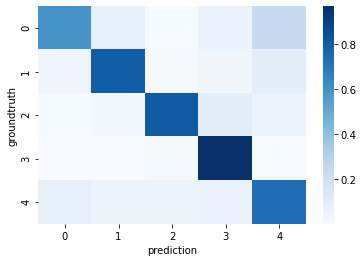

In [ ]:
heatmap_df = pd.DataFrame(columns={"groundtruth","prediction","value"})
for key in prediction_distribution_per_class.keys():
    for pred_key in prediction_distribution_per_class[key].keys():
        value = prediction_distribution_per_class[key][pred_key]/validation_df.query("label==@key").count()[0]
        heatmap_df = heatmap_df.append({"groundtruth":key,"prediction":pred_key,"value":value}, ignore_index=True)   

heatmap = heatmap_df.pivot(index='groundtruth', columns='prediction', values='value')
sns.heatmap(heatmap,cmap="Blues")

In [ ]:
test_folder = '../input/cassava-leaf-disease-classification/test_images/'
submission_df = pd.DataFrame(columns={"image_id","label"})
submission_df["image_id"] =  os.listdir(test_folder)
submission_df["label"] = 0

In [ ]:
submission_df["label"] = run_predictions_over_image_list(submission_df["image_id"], test_folder)

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


In [ ]:
submission_df

,image_id,label
0,2216849948.jpg,4


In [ ]:
submission_df.to_csv("submission.csv", index=False)